In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


## Подготовка данных

1. Собрать датасет от 15 изображений одно персонажа (Чем более разнооразнее и больше данных тем лучше будет качество)
2. Кропнуть и заресайзить лица, тут можно обрабатывать сразу все https://www.birme.net/



## Install Requirements

In [ ]:
!git clone https://github.com/huggingface/diffusers
%pip install git+https://github.com/huggingface/diffusers
%pip install triton
%pip install accelerate transformers ftfy gradio natsort safetensors
%pip install bitsandbytes

In [4]:
!pip list | grep torch

torch                            2.2.1+cu121
torchaudio                       2.2.1+cu121
torchdata                        0.7.1
torchsummary                     1.5.1
torchtext                        0.17.1
torchvision                      0.17.1+cu121


## Download model and convert model

In [ ]:
!wget -O civitai_midel.ckpt https://civitai.com/api/download/models/201259?type=Model&format=SafeTensor&size=pruned&fp=fp16
!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml

In [ ]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='/content/civitai_midel.ckpt'\
      --original_config_file='/content/v1-inference.yaml'\
      --dump_path='/content/cache_dir/models/civitai_model'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Сохранить копию на диск чтобы не конвертировать веса при каждом запуске

In [6]:
!cp -r /content/cache_dir/models/civitai_model/ /content/drive/MyDrive/shared/stable-diffusion-weights/CyberRealistic

## Settings and run

# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

remove `--train_text_encoder` flag to reduce memory usage further, degrades output quality.

In [ ]:
#@markdown Upload your images by running this cell.

#@markdown OR

#@markdown You can use the file manager on the left panel to upload (drag and drop) to each `instance_data_dir` (it uploads faster). You can also upload your own class images in `class_data_dir` if u don't wanna generate with SD.

import os
from google.colab import files
import shutil

for c in concepts_list:
    print(f"Uploading instance images for `{c['instance_prompt']}`")
    uploaded = files.upload()
    for filename in uploaded.keys():
        dst_path = os.path.join(c['instance_data_dir'], filename)
        shutil.move(filename, dst_path)

In [ ]:
import os
os.environ['INSTANCE_DIR'] = "/content/drive/MyDrive/shared/ana_de_armas/instance_images2"
os.environ['CLASS_DIR'] = "/content/drive/MyDrive/shared/ana_de_armas/class_images2"

os.environ['MODEL_NAME'] = "/content/drive/MyDrive/shared/stable-diffusion-weights/CyberRealistic"
os.environ['OUTPUT_DIR'] = "/content/drive/MyDrive/shared/stable-diffusion-weights/dreambooth/experiment_ana_2_400"


In [ ]:
!python3 /content/diffusers/examples/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="a photo of sks woman face" \
  --class_prompt="a photo of woman face " \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=2e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --gradient_accumulation_steps=1 \
  --num_class_images=500 \
  --max_train_steps=800 \
  --checkpointing_steps=800 \
  --use_8bit_adam \
  --mixed_precision="no"\
  --train_text_encoder \



## Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display
import os

model_path = os.environ['OUTPUT_DIR']

pipe = StableDiffusionPipeline.from_pretrained(model_path, safety_checker=None, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
g_cuda=None

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 345252 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/35 [00:00<?, ?it/s]

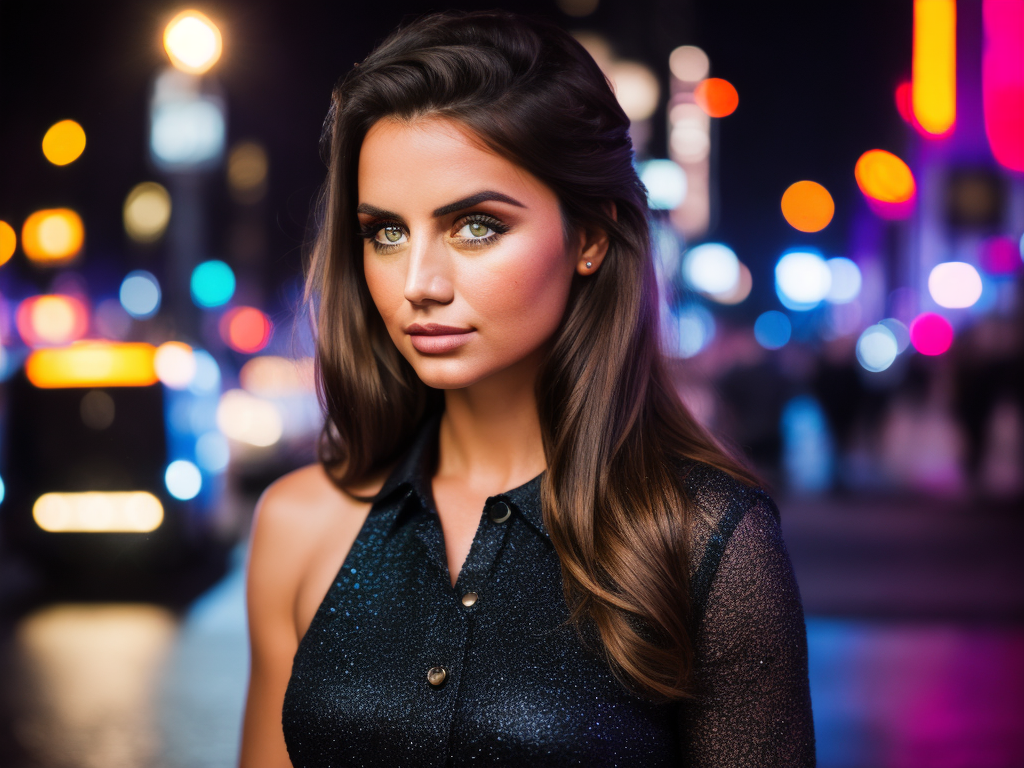

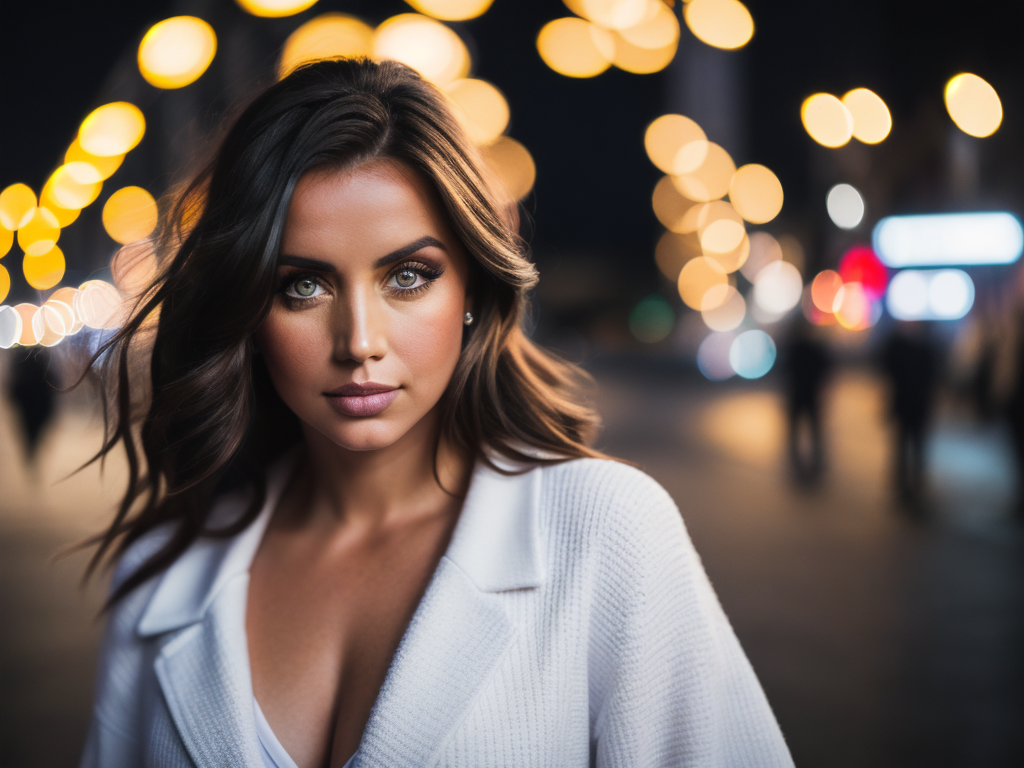

In [ ]:
#@title Run for generating images.

prompt = "portrait of sks woman face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes" #@param {type:"string"}
negative_prompt = "naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 35 #@param {type:"number"}
height = 768 #@param {type:"number"}
width = 1024 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

for img in images:
    display(img)

In [ ]:
token = ""
promt_list = [
    {
     "name": "kitchen",
     "prompt":f"close up portrait of {token} woman face, in the kitchen, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
     "name": "forest",
     "prompt":f"portrait of {token} woman face, in the forest, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands disconnected limbs, mutation, ugly, blurry, amputation",
    },
    {
     "name": "street",
     "prompt":f"portrait of {token} woman face, on the street, lights, midnight, NY, standing, 4K, raw, hrd, hd, high quality, realism, sharp focus,  beautiful eyes, detailed eyes",
     "n_prompt":"naked, nsfw, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra limb, missing limb, floating limbs, mutated hands, mutation, ugly, blurry",
    },
]

from PIL import Image
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
seed = 147525234
repeat = 2
num_samples = 2
guidance_scale = 7.5
num_inference_steps = 35
height = 768
width = 1024

save_folder = "/content/drive/MyDrive/shared/ana_de_armas/report_images"
# save_mode = "with_train_token"
save_mode = "base_model"

for idx, sample in enumerate(promt_list):
  prompt = sample.get("prompt")
  negative_prompt = sample.get("n_prompt")
  name = sample.get("name")
  image_list = []
  for _ in range(repeat):
    generator = torch.Generator("cuda").manual_seed(seed)
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        ).images
    image_list.extend(images)
    seed+=345324

  img_grid = image_grid(image_list, num_samples, repeat)
  save_path = os.path.join(save_folder, save_mode, f"{height}x{width}")
  os.makedirs(save_path, exist_ok=True)
  img_grid.save(os.path.join(save_path, f"{name}.jpg"))




  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

In [ ]:
# Train lora
https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py

# load lora
pipe.load_lora_weights("path/to/weights/diffusion_pytorch_lora.bin")